This notebook is aimed at using plotly to find diurnal variations in data.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import time
import plotly.express as pe
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.colors as colors
import matplotlib.pyplot as plt

from datetime import datetime

#
os.chdir('/Users/gaurav/UAH/temperature_modelling/')

from lib import dataprocess as dp
from lib import crowdqc as cqc

In [384]:
dp.plot_(grouped_data_normal[grouped_data_normal.station=='KWIMADIS162'], animation_frame_comp='hour',resample=False)


Analysis of Fault stations

In [7]:
data = pd.read_csv('/Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/master_Madison_pws_.csv')

In [154]:
missing_stations = []
for x in non_flags:
    fitch_38 = data[data.stationID==x]
    fitch_38 = fitch_38[(fitch_38.obsTimeLocal>'2021-06-00') & (fitch_38.obsTimeLocal<'2021-06-30')]


    fitch_38.obsTimeLocal = pd.to_datetime(fitch_38.obsTimeLocal)
    fitch_38 = fitch_38.resample('H', on='obsTimeLocal').mean().reset_index()
    obs_by_day = fitch_38.count()['temperature']
    obs_by_day = obs_by_day/30
    obs = fitch_38.resample('D', on='obsTimeLocal').mean().reset_index().count()['temperature']

    if obs_by_day<18 or obs < 22:
        print(f'{x} has {obs_by_day} observations per day in June 2021')
   
        print(f'{x} has {obs} observations in June 2021')

        missing_stations.append(x)

KWIFITCH35 has 15.933333333333334 observations per day in June 2021
KWIFITCH35 has 21 observations in June 2021
KWIMADIS162 has 14.4 observations per day in June 2021
KWIMADIS162 has 18 observations in June 2021
KWIMADIS353 has 4.9 observations per day in June 2021
KWIMADIS353 has 7 observations in June 2021
KWIMADIS65 has 12.0 observations per day in June 2021
KWIMADIS65 has 15 observations in June 2021
KWIMONON7 has 7.466666666666667 observations per day in June 2021
KWIMONON7 has 10 observations in June 2021
KWIWAUNA18 has 14.533333333333333 observations per day in June 2021
KWIWAUNA18 has 19 observations in June 2021


In [267]:
print(missing_stations)
print(flags)

['KWIFITCH35', 'KWIMADIS162', 'KWIMADIS353', 'KWIMADIS65', 'KWIMONON7', 'KWIWAUNA18']
['KWIFITCH38' 'KWIMADIS298' 'KWIMADIS308' 'KWIMADIS50' 'KWIMIDDL19'
 'KWIMIDDL23' 'KWIMIDDL39']


In [30]:
[x for x in grouped_data.columns if 'value' in x.lower()]

['valueImperviousfraction',
 'valueTreefraction',
 'valueBuildingheight',
 'valueNearestDistWater',
 'valueWaterfraction',
 'valueBuildingfraction']

In [34]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')
predictions2,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column='valueBuildingfraction')

for hour in predictions2.keys():
    # if hour in [7,8]:
    figx = pe.scatter(grouped_data.query("hour==@hour"),x = 'valueBuildingfraction', y='temperature',color='station',title=f'Temperature Pattern for Normal Stations at hour : {hour} ')
    figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueBuildingfraction, y=predictions2[hour][0.02], mode='lines', name='5% line'))
    figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueBuildingfraction, y=predictions2[hour][0.98], mode='lines', name='95% line'))
    figx.show()

In [35]:
import pandas as pd
wind_data = pd.read_csv('Analytics/wind_data.csv')
wind_data.DATE = pd.to_datetime(wind_data.DATE)
wind_data = wind_data[(wind_data.DATE.dt.year==2021) & (wind_data.DATE.dt.month==6)]

/var/folders/qr/fds_zg7j76g51mq0zmqdqfnc0000gn/T/ipykernel_92968/2175824136.py:2: DtypeWarning:

Columns (3,21,27,28,29,31,32,33,38,42,43,44,49,50,52,54,56,64,70,72,73,74,76,77,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.



In [52]:
import pandas as pd
wind_data = pd.read_csv('Analytics/wind_data.csv')
wind_data.DATE = pd.to_datetime(wind_data.DATE)
wind_data = wind_data[(wind_data.DATE.dt.year==2021) & (wind_data.DATE.dt.month==6)]

wind_cols = [k for k in  wind_data.columns if 'wind' in k.lower() or "wnd" in k.lower()]
wind_cols = ['STATION', 'DATE', 'SOURCE',]+ wind_cols
wind_data_ = wind_data[wind_cols]
wind_data_.isna().sum()

wind_data_seg = wind_data_[['STATION', 'DATE','HourlyWindDirection','HourlyWindSpeed']]
# wind_data_mean = wind_data_seg.resample('H', on='DATE').mean().reset_index()
wind_data_seg['hour'] = wind_data_seg.DATE.dt.hour
wind_data_seg = wind_data_seg[(~wind_data_seg.HourlyWindDirection.isna()) & (wind_data_seg.HourlyWindDirection != 'VRB')]

import numpy as np

wind_data_seg['HourlyWindDirection']  = wind_data_seg['HourlyWindDirection'].astype(int)
wind_data_mean = wind_data_seg.groupby(['STATION','hour']).mean().reset_index()
wind_data_mean['horizontal_wind'] =wind_data_mean['HourlyWindSpeed'] * np.cos(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean['vertical_wind'] =wind_data_mean['HourlyWindSpeed'] * np.sin(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]


In [64]:
import numpy as np

wind_data_seg['HourlyWindDirection']  = wind_data_seg['HourlyWindDirection'].astype(int)
wind_data_mean = wind_data_seg.groupby(['STATION','hour']).mean().reset_index()
wind_data_mean['horizontal_wind'] =wind_data_mean['HourlyWindSpeed'] * np.cos(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean['vertical_wind'] =wind_data_mean['HourlyWindSpeed'] * np.sin(np.radians(wind_data_mean['HourlyWindDirection']))
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]


In [67]:
wind_data_mean = wind_data_mean[[ 'hour', 'horizontal_wind', 'vertical_wind']]
wind_data_mean

,hour,horizontal_wind,vertical_wind
0,0,-4.106722,4.095709
1,1,-7.755561,4.210926
2,2,-0.351005,4.486290
3,3,-1.197071,3.288924
4,4,-1.151403,2.887605
5,5,-5.401521,-0.952434
6,6,-5.854072,-0.471334
7,7,-5.840628,1.373703
8,8,-6.944758,1.082199
9,9,-8.139807,-1.343888


# Evaluation of features

<AxesSubplot:>

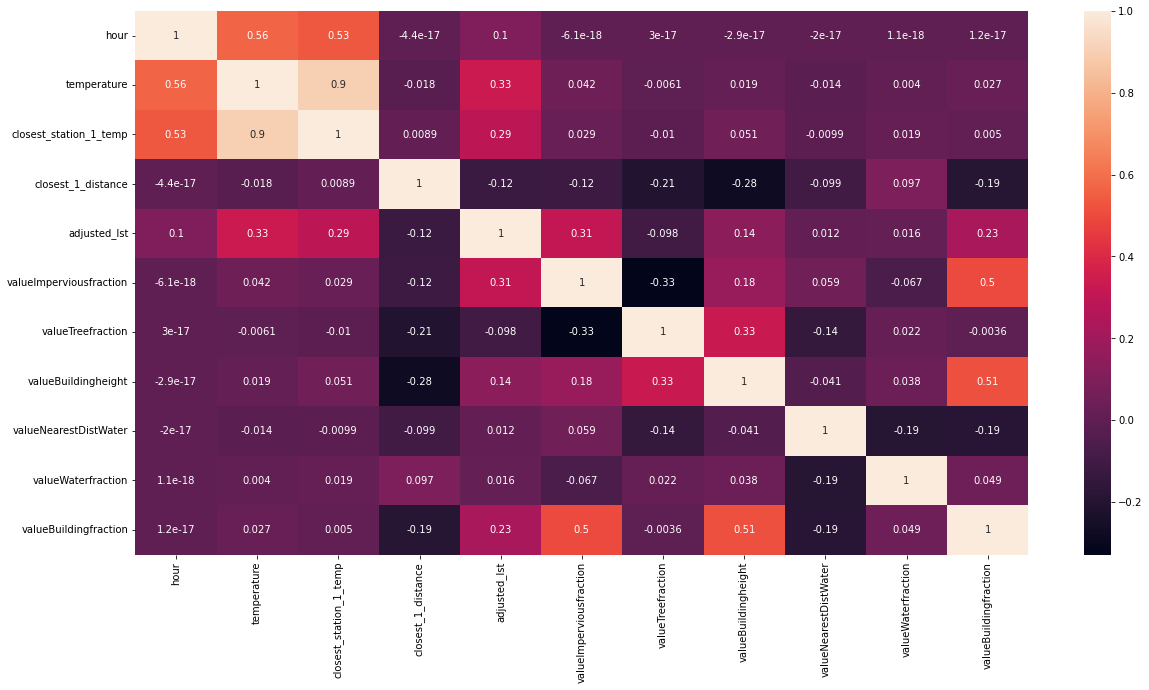

In [513]:
grouped_data = pd.read_csv('Analytics/temp_data/grouped_data_untouched.csv')

grouped_data = grouped_data[['station', 'hour', 'temperature',
         'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater', 'valueWaterfraction', 'valueBuildingfraction']]

import seaborn as sns
plt.figure(figsize=(20,10))
corr = grouped_data.corr()
sns.heatmap(corr, annot=True)

In [8]:
feature_cols = ['adjusted_lst','valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
 'valueNearestDistWater', 'valueWaterfraction', 'valueBuildingfraction']


def find_frequent(outliers_dict):
    hash_map = dict()
    hash_map_tree = dict()

    for hrs in outliers_dict.keys():
        val = outliers_dict[hrs]
        for v in val:
            hash_map[v] = 1 + hash_map.get(v,0)
            hash_map_tree[v] = 1 + hash_map_tree.get(v,0)

    hash_map_tree = {k: v for k, v in sorted(hash_map_tree.items(), key=lambda item: item[1],reverse=True)}
    return hash_map_tree

In [18]:
for feature in feature_cols:
    predictions2,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column=feature)
    # top_5 = find_frequent(outliers_lst)
    # top_5 = {k:v for k,v in sorted(top_5.items(),key=lambda x: x[1],reverse=True)[:5]}
    # print(feature)
    for keys in outliers_lst.keys():
        if keys in [10,12,13]:
            # print(f'{feature} ')
            print(feature,keys,outliers_lst[keys])

# predictions1,outliers_lst = cqc.filter_quartiles(grouped_data,feature_column=feature)

# for hour in predictions1.keys():
#     # if hour in [7,8]:
#     figx = pe.scatter(grouped_data.query("hour==@hour"),x = 'valueTreefraction', y='temperature',color='valueNearestDistWater',title=f'Temperature Pattern for Normal Stations at hour : {hour} ')
#     figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueTreefraction, y=predictions1[hour][quants[0]], mode='lines', name='5% line'))
#     figx.add_trace(go.Scatter(x=grouped_data.query("hour==@hour").valueTreefraction, y=predictions1[hour][quants[1]], mode='lines', name='95% line'))
#     figx.show()

adjusted_lst 10 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS301', 'KWIMADIS47']
adjusted_lst 12 ['KWIMADIS138', 'KWIMADIS233', 'KWIMADIS301']
adjusted_lst 13 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS233', 'KWIMADIS301']
valueImperviousfraction 10 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS301', 'KWIMADIS47']
valueImperviousfraction 12 ['KWIMADIS138', 'KWIMADIS233', 'KWIMADIS301']
valueImperviousfraction 13 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS233', 'KWIMADIS301']
valueTreefraction 10 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS301', 'KWIMADIS47']
valueTreefraction 12 ['KWIMADIS138', 'KWIMADIS233', 'KWIMADIS301']
valueTreefraction 13 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS233', 'KWIMADIS301']
valueBuildingheight 10 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS301', 'KWIMADIS47']
valueBuildingheight 12 ['KWIMADIS138', 'KWIMADIS233', 'KWIMADIS301']
valueBuildingheight 13 ['KWIMADIS138', 'KWIMCFAR8', 'KWIMADIS233', 'KWIMADIS301']
valueNearestDistWater 10 ['KWIMADIS138', 'KWIMADIS301', 'KWIMADIS47']
valueNearestDistW